
<a id='coleman-policy-iter'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Optimal Growth II: Time Iteration

## Colab Instructions

Colab does not have direct Julia support, and it must be installed each time you are working on a notebook.  

Instructions:

1. Ignore any errors about a missing kernel when loading the notebook.  Choose `Run Anyway` when it prompts that the notebook wasn't authored by google.

2. Run the cell below this with `Shift+Enter`.
    -  It will **5 to 8 minutes** the first time you run it for Julia and key packages to install

3. Refresh your browser, and then execute any code as normal.
  - Even after installation, there will be more precompiling latency for some packages. 

In [ ]:
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
    julia -e 'using Pkg; pkg"add IJulia InstantiateFromURL; precompile;"'
    julia -e 'using InstantiateFromURL; github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0", instantiate = true, precompile = false); using Plots, Distributions, Parameters, NLsolve, ForwardDiff, Expectations'
    echo 'Done'
fi


## Contents

- [Optimal Growth II: Time Iteration](#Optimal-Growth-II:-Time-Iteration)  
  - [Overview](#Overview)  
  - [The Euler Equation](#The-Euler-Equation)  
  - [Comparison with Value Function Iteration](#Comparison-with-Value-Function-Iteration)  
  - [Implementation](#Implementation)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

In this lecture we’ll continue our [earlier study](optgrowth.html) of the stochastic optimal growth model.

In that lecture we solved the associated discounted dynamic programming problem using value function iteration.

The beauty of this technique is its broad applicability.

With numerical problems, however, we can often attain higher efficiency in specific applications by deriving methods that are carefully tailored to the application at hand.

The stochastic optimal growth model has plenty of structure to exploit for this purpose, especially when we adopt some concavity and smoothness assumptions over primitives.

We’ll use this structure to obtain an **Euler equation**  based method that’s more efficient than value function iteration for this and some other closely related applications.

In a [subsequent lecture](egm_policy_iter.html) we’ll see that the numerical implementation part of the Euler equation method can be further adjusted to obtain even more efficiency.

## The Euler Equation

Let’s take the model set out in [the stochastic growth model lecture](optgrowth.html) and add the assumptions that

1. $ u $ and $ f $ are continuously differentiable and strictly concave  
1. $ f(0) = 0 $  
1. $ \lim_{c \to 0} u'(c) = \infty $ and $ \lim_{c \to \infty} u'(c) = 0 $  
1. $ \lim_{k \to 0} f'(k) = \infty $ and $ \lim_{k \to \infty} f'(k) = 0 $  


The last two conditions are usually called **Inada conditions**.

Recall the Bellman equation


<a id='equation-cpi-fpb30'></a>
$$
v^*(y) = \max_{0 \leq c \leq y}
    \left\{
        u(c) + \beta \int v^*(f(y - c) z) \phi(dz)
    \right\}
\quad \text{for all} \quad
y \in \mathbb R_+ \tag{1}
$$

Let the optimal consumption policy be denoted by $ c^* $.

We know that $ c^* $ is a $ v^* $ greedy policy, so that $ c^*(y) $ is the maximizer in [(1)](#equation-cpi-fpb30).

The conditions above imply that

- $ c^* $ is the unique optimal policy for the stochastic optimal growth model  
- the optimal policy is continuous, strictly increasing and also **interior**, in the sense that $ 0 < c^*(y) < y $ for all strictly positive $ y $, and  
- the value function is strictly concave and continuously differentiable, with  



<a id='equation-cpi-env'></a>
$$
(v^*)'(y) = u' (c^*(y) ) := (u' \circ c^*)(y) \tag{2}
$$

The last result is called the **envelope condition** due to its relationship with the [envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem).

To see why [(2)](#equation-cpi-env) might be valid, write the Bellman equation in the equivalent
form

$$
v^*(y) = \max_{0 \leq k \leq y}
    \left\{
        u(y-k) + \beta \int v^*(f(k) z) \phi(dz)
    \right\},
$$

differentiate naively with respect to $ y $,  and then  evaluate at the optimum.

Section 12.1 of [EDTC](http://johnstachurski.net/edtc.html) contains full proofs of these results, and closely related discussions can be found in many other texts.

Differentiability of the value function and iteriority of the optimal policy
imply that optimal consumption satisfies the first order condition associated
with [(1)](#equation-cpi-fpb30), which is


<a id='equation-cpi-foc'></a>
$$
u'(c^*(y)) = \beta \int (v^*)'(f(y - c^*(y)) z) f'(y - c^*(y)) z \phi(dz) \tag{3}
$$

Combining [(2)](#equation-cpi-env) and the first-order condition [(3)](#equation-cpi-foc) gives the famous **Euler equation**


<a id='equation-cpi-euler'></a>
$$
(u'\circ c^*)(y)
= \beta \int (u'\circ c^*)(f(y - c^*(y)) z) f'(y - c^*(y)) z \phi(dz) \tag{4}
$$

We can think of the Euler equation as a functional equation


<a id='equation-cpi-euler-func'></a>
$$
(u'\circ \sigma)(y)
= \beta \int (u'\circ \sigma)(f(y - \sigma(y)) z) f'(y - \sigma(y)) z \phi(dz) \tag{5}
$$

over interior consumption policies $ \sigma $, one solution of which is the optimal policy $ c^* $.

Our aim is to solve the functional equation [(5)](#equation-cpi-euler-func) and hence obtain $ c^* $.

### The Coleman Operator

Recall the Bellman operator


<a id='equation-fcbell20-coleman'></a>
$$
Tw(y) := \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int w(f(y - c) z) \phi(dz)
\right\} \tag{6}
$$

Just as we introduced the Bellman operator to solve the Bellman equation, we
will now introduce an operator over policies to help us solve the Euler
equation.

This operator $ K $ will act on the set of all $ \sigma \in \Sigma $
that are continuous, strictly increasing and interior (i.e., $ 0 < \sigma(y) < y $ for all strictly positive $ y $).

Henceforth we denote this set of policies by $ \mathscr P $

1. The operator $ K $ takes as its argument a $ \sigma \in \mathscr P $ and  
1. returns a new function $ K\sigma $,  where $ K\sigma(y) $ is the $ c \in (0, y) $ that solves  



<a id='equation-cpi-coledef'></a>
$$
u'(c)
= \beta \int (u' \circ \sigma) (f(y - c) z ) f'(y - c) z \phi(dz) \tag{7}
$$

We call this operator the **Coleman operator** to acknowledge the work of [[Col90]](../zreferences.html#coleman1990)  (although many people have studied this and other closely related iterative techniques).

In essence, $ K\sigma $ is the consumption policy that the Euler equation tells
you to choose today when your future consumption policy is $ \sigma $.

The  important thing to note about $ K $ is that, by
construction, its fixed points coincide with solutions to the functional
equation [(5)](#equation-cpi-euler-func).

In particular, the optimal policy $ c^* $ is a fixed point.

Indeed, for fixed $ y $, the value $ Kc^*(y) $ is the $ c $ that
solves

$$
u'(c)
= \beta \int (u' \circ c^*) (f(y - c) z ) f'(y - c) z \phi(dz)
$$

In view of the Euler equation, this is exactly $ c^*(y) $.

### Is the Coleman Operator Well Defined?

In particular, is there always a unique $ c \in (0, y) $ that solves
[(7)](#equation-cpi-coledef)?

The answer is yes, under our assumptions.

For any $ \sigma \in \mathscr P $, the right side of [(7)](#equation-cpi-coledef)

- is continuous and strictly increasing in $ c $ on $ (0, y) $  
- diverges to $ +\infty $ as $ c \uparrow y $  


The left side of [(7)](#equation-cpi-coledef)

- is continuous and strictly decreasing in $ c $ on $ (0, y) $  
- diverges to $ +\infty $ as $ c \downarrow 0 $  


Sketching these curves and using the information above will convince you that they cross exactly once as $ c $ ranges over $ (0, y) $.

With a bit more analysis, one can show in addition that $ K \sigma \in \mathscr P $
whenever $ \sigma \in \mathscr P $.

## Comparison with Value Function Iteration

How does Euler equation time iteration compare with value function iteration?

Both can be used to compute the optimal policy, but is one faster or more
accurate?

There are two parts to this story.

First, on a theoretical level, the two methods are essentially isomorphic.

In particular, they converge at  the same rate.

We’ll prove this in just a moment.

The other side to the story is the speed of the numerical implementation.

It turns out that, once we actually implement these two routines, time iteration is faster and more accurate than value function iteration.

More on this below.

### Equivalent Dynamics

Let’s talk about the theory first.

To explain the connection between the two algorithms, it helps to understand
the notion of equivalent dynamics.

(This concept is very helpful in many other contexts as well).

Suppose that we have a function $ g \colon X \to X $ where $ X $ is a given set.

The pair $ (X, g) $ is sometimes called a **dynamical system** and we
associate it with trajectories of the form

$$
x_{t+1} = g(x_t), \qquad x_0 \text{ given}
$$

Equivalently, $ x_t = g^t(x_0) $, where $ g $ is the $ t $-th
composition of $ g $ with itself.

Here’s the picture

<img src="_static/figures/col_pol_composition.png" style="width:40%;">

  
Now let another function $ h \colon Y \to Y $ where $ Y $ is another set.

Suppose further that

- there exists a bijection $ \tau $ from $ X $ to $ Y $  
- the two functions **commute** under $ \tau $, which is to say that
  $ \tau(g(x)) = h (\tau(x)) $ for all $ x \in X $  


The last statement can be written more simply as

$$
\tau \circ g = h \circ \tau
$$

or, by applying $ \tau^{-1} $ to both sides


<a id='equation-cpi-ghcom'></a>
$$
g = \tau^{-1} \circ h \circ \tau \tag{8}
$$

Here’s a commutative diagram that illustrates

<img src="_static/figures/col_pol_bij1.png" style="width:50%;">

  
Here’s a similar figure that traces out the action of the maps on a point
$ x \in X $

<img src="_static/figures/col_pol_bij2.png" style="width:50%;">

  
Now, it’s easy to check from [(8)](#equation-cpi-ghcom) that $ g^2 = \tau^{-1} \circ h^2 \circ \tau $ holds.

In fact, if you like proofs by induction, you won’t have trouble showing that

$$
g^n = \tau^{-1} \circ h^n \circ \tau
$$

is valid for all $ n $.

What does this tell us?

It tells us that the following are equivalent

- iterate $ n $ times with $ g $, starting at $ x $  
- shift $ x $ to $ Y $ using $ \tau $,  iterate $ n $ times with $ h $ starting at $ \tau(x) $, and shift the result $ h^n(\tau(x)) $ back to $ X $ using $ \tau^{-1} $  


We end up with exactly the same object.

### Back to Economics

Have you guessed where this is leading?

What we’re going to show now is that the operators $ T $ and $ K $
commute under a certain bijection.

The implication is that they have exactly the same rate of convergence.

To make life a little easier, we’ll assume in the following analysis (although not
always in our applications) that $ u(0) = 0 $.

#### A Bijection

Let $ \mathscr V $ be all strictly concave, continuously differentiable functions $ v $ mapping $ \mathbb R_+ $ to itself and satisfying $ v(0) = 0 $ and $ v'(y) > u'(y) $ for all positive $ y $.

For $ v \in \mathscr V $ let

$$
M v := h \circ v' \qquad \text{where } h := (u')^{-1}
$$

Although we omit details, $ \sigma := M v $ is actually the unique
$ v $-greedy policy.

- See proposition 12.1.18 of [EDTC](http://johnstachurski.net/edtc.html)  


It turns out that $ M $ is a bijection from $ \mathscr V $ to $ \mathscr P $.

A (solved) exercise below asks you to confirm this.

#### Commutative Operators

It is an additional solved exercise (see below) to show that $ T $ and $ K $ commute under $ M $, in the sense that


<a id='equation-cpi-ed-tk'></a>
$$
M \circ T = K \circ M \tag{9}
$$

In view of the preceding discussion, this implies that

$$
T^n = M^{-1} \circ K^n \circ M
$$

Hence, $ T $ and $ K $ converge at exactly the same rate!

## Implementation

We’ve just shown that the operators $ T $ and $ K $ have the same rate of convergence.

However, it turns out that, once numerical approximation is taken into account, significant differences arises.

In particular, the image of policy functions under $ K $ can be calculated faster and with greater accuracy than the image of value functions under $ T $.

Our intuition for this result is that

- the Coleman operator exploits more information because it uses first order and envelope conditions  
- policy functions generally have less curvature than value functions, and hence admit more accurate approximations based on grid point information  

### The Operator

Here’s some code that implements the Coleman operator.

### Setup

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0")

In [2]:
using LinearAlgebra, Statistics
using BenchmarkTools, Interpolations, Parameters, Plots, QuantEcon, Roots
using Optim, Random

In [3]:
using BenchmarkTools, Interpolations, Parameters, Plots, QuantEcon, Roots

gr(fmt = :png);

In [4]:
function K!(Kg, g, grid, β, ∂u∂c, f, f′, shocks)
# This function requires the container of the output value as argument Kg

    # Construct linear interpolation object
    g_func = LinearInterpolation(grid, g, extrapolation_bc=Line())

    # solve for updated consumption value
    for (i, y) in enumerate(grid)
        function h(c)
            vals = ∂u∂c.(g_func.(f(y - c) * shocks)) .* f′(y - c) .* shocks
            return ∂u∂c(c) - β * mean(vals)
        end
        Kg[i] = find_zero(h, (1e-10, y - 1e-10))
    end
    return Kg
end

# The following function does NOT require the container of the output value as argument
K(g, grid, β, ∂u∂c, f, f′, shocks) =
    K!(similar(g), g, grid, β, ∂u∂c, f, f′, shocks)

K (generic function with 1 method)

It has some similarities to the code for the Bellman operator in our [optimal growth lecture](optgrowth.html).

For example, it evaluates integrals by Monte Carlo and approximates functions using linear interpolation.

Here’s that Bellman operator code again, which needs to be executed because we’ll use it in some tests below

In [5]:
using Optim

function T(w, grid, β, u, f, shocks, Tw = similar(w);
                          compute_policy = false)

    # apply linear interpolation to w
    w_func = LinearInterpolation(grid, w, extrapolation_bc=Line())

    if compute_policy
        σ = similar(w)
    end

    # set Tw[i] = max_c { u(c) + β E w(f(y  - c) z)}
    for (i, y) in enumerate(grid)
        objective(c) =  u(c) + β * mean(w_func.(f(y - c) .* shocks))
        res = maximize(objective, 1e-10, y)

        if compute_policy
            σ[i] = Optim.maximizer(res)
        end
        Tw[i] = Optim.maximum(res)
    end

    if compute_policy
        return Tw, σ
    else
        return Tw
    end
end

T (generic function with 2 methods)

### Testing on the Log / Cobb–Douglas case

As we [did for value function iteration](optgrowth.html), let’s start by
testing our method in the presence of a model that does have an analytical
solution.

Here’s an object containing data from the log-linear growth model we used in the [value function iteration lecture](optgrowth.html)

In [6]:
isoelastic(c, γ) = isone(γ) ? log(c) : (c^(1 - γ) - 1) / (1 - γ)
Model = @with_kw (α = 0.65,                            # Productivity parameter
                  β = 0.95,                            # Discount factor
                  γ = 1.0,                             # Risk aversion
                  μ = 0.0,                             # First parameter in lognorm(μ, σ)
                  s = 0.1,                             # Second parameter in lognorm(μ, σ)
                  grid = range(1e-6, 4, length = 200), # Grid
                  grid_min = 1e-6,                     # Smallest grid point
                  grid_max = 4.0,                      # Largest grid point
                  grid_size = 200,                     # Number of grid points
                  u = (c, γ = γ) -> isoelastic(c, γ),  # utility function
                  ∂u∂c = c -> c^(-γ),                  # u′
                  f = k -> k^α,                        # production function
                  f′ = k -> α * k^(α - 1),             # f′
                  )

##NamedTuple_kw#262 (generic function with 2 methods)

Next we generate an instance

In [7]:
m = Model();

We also need some shock draws for Monte Carlo integration

In [8]:
using Random
Random.seed!(42) # for reproducible results.

shock_size = 250 # number of shock draws in Monte Carlo integral
shocks = collect(exp.(m.μ .+ m.s * randn(shock_size))); # generate shocks

As a preliminary test, let’s see if $ K c^* = c^* $, as implied by the
theory

In [9]:
function verify_true_policy(m, shocks, c_star)
    # compute (Kc_star)
    @unpack grid, β, ∂u∂c, f, f′ = m
    c_star_new = K(c_star, grid, β, ∂u∂c, f, f′, shocks)

    # plot c_star and Kc_star
    plot(grid, c_star, label = "optimal policy cc_star")
    plot!(grid, c_star_new, label = "Kc_star")
    plot!(legend = :topleft)
end

verify_true_policy (generic function with 1 method)

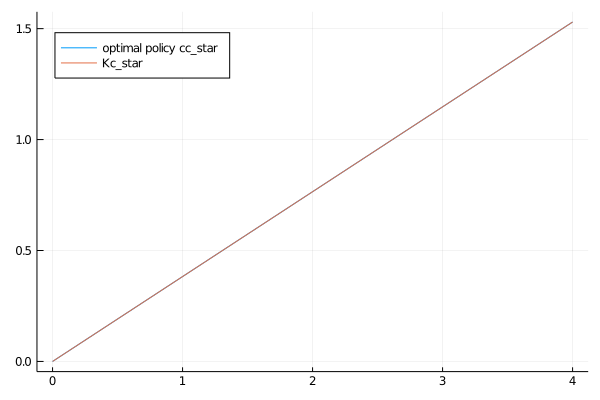

In [10]:
c_star = (1 - m.α * m.β) * m.grid # true policy (c_star)
verify_true_policy(m, shocks, c_star)

We can’t really distinguish the two plots, so we are looking good, at least
for this test.

Next let’s try iterating from an arbitrary initial condition and see if we
converge towards $ c^* $.

The initial condition we’ll use is the one that eats the whole pie: $ c(y) = y $

In [11]:
function check_convergence(m, shocks, c_star, g_init; n_iter = 15)
    @unpack grid, β, ∂u∂c, f, f′ = m
    g = g_init;
    plot(m.grid, g, lw = 2, alpha = 0.6, label = "intial condition c(y) = y")
    for i in 1:n_iter
        new_g = K(g, grid, β, ∂u∂c, f, f′, shocks)
        g = new_g
        plot!(grid, g, lw = 2, alpha = 0.6, label = "")
    end
    plot!(grid, c_star, color = :black, lw = 2, alpha = 0.8,
          label = "true policy function c_star")
    plot!(legend = :topleft)
end

check_convergence (generic function with 1 method)

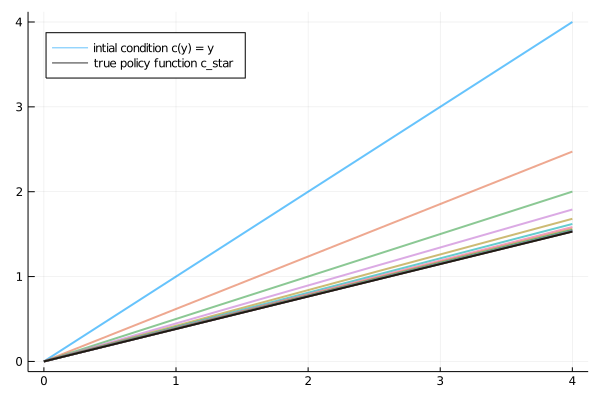

In [12]:
check_convergence(m, shocks, c_star, m.grid, n_iter = 15)

We see that the policy has converged nicely, in only a few steps.

Now let’s compare the accuracy of iteration using the Coleman and Bellman operators.

We’ll generate

1. $ K^n c $ where $ c(y) = y $  
1. $ (M \circ T^n \circ M^{-1}) c $ where $ c(y) = y $  


In each case we’ll compare the resulting policy to $ c^* $.

The theory on equivalent dynamics says we will get the same policy function
and hence the same errors.

But in fact we expect the first method to be more accurate for reasons
discussed above

In [13]:
function iterate_updating(func, arg_init; sim_length = 20)
    arg = arg_init;
    for i in 1:sim_length
        new_arg = func(arg)
        arg = new_arg
    end
    return arg
end

function compare_error(m, shocks, g_init, w_init; sim_length = 20)
    @unpack grid, β, u, ∂u∂c, f, f′ = m
    g, w = g_init, w_init

    # two functions for simplification
    bellman_single_arg(w) = T(w, grid, β, u, f, shocks)
    coleman_single_arg(g) = K(g, grid, β, ∂u∂c, f, f′, shocks)

    g = iterate_updating(coleman_single_arg, grid, sim_length = 20)
    w = iterate_updating(bellman_single_arg, u.(grid), sim_length = 20)
    new_w, vf_g = T(w, grid, β, u, f, shocks, compute_policy = true)

    pf_error = c_star - g
    vf_error = c_star - vf_g

    plot(grid, zero(grid), color = :black, lw = 1)
    plot!(grid, pf_error, lw = 2, alpha = 0.6, label = "policy iteration error")
    plot!(grid, vf_error, lw = 2, alpha = 0.6, label = "value iteration error")
    plot!(legend = :bottomleft)
end

compare_error (generic function with 1 method)

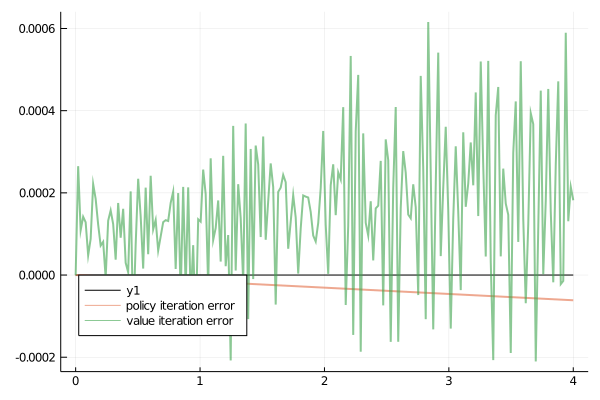

In [14]:
compare_error(m, shocks, m.grid, m.u.(m.grid), sim_length=20)

As you can see, time iteration is much more accurate for a given
number of iterations.

## Exercises

### Exercise 1

Show that [(9)](#equation-cpi-ed-tk) is valid.  In particular,

- Let $ v $ be strictly concave and continuously differentiable on $ (0, \infty) $  
- Fix $ y \in (0, \infty) $ and show that $ MTv(y) = KMv(y) $  

### Exercise 2

Show that $ M $ is a bijection from $ \mathscr V $ to $ \mathscr P $.

### Exercise 3

Consider the same model as above but with the CRRA utility function

$$
u(c) = \frac{c^{1 - \gamma} - 1}{1 - \gamma}
$$

Iterate 20 times with Bellman iteration and Euler equation time iteration

- start time iteration from $ c(y) = y $  
- start value function iteration from $ v(y) = u(y) $  
- set $ \gamma = 1.5 $  


Compare the resulting policies and check that they are close.

### Exercise 4

Do the same exercise, but now, rather than plotting results, benchmark both approaches with 20
iterations.

## Solutions

### Solution to Exercise 1

Let $ T, K, M, v $ and $ y $ be as stated in the exercise.

Using the envelope theorem, one can show that $ (Tv)'(y) = u'(c(y)) $
where $ c(y) $ solves


<a id='equation-cpi-foo'></a>
$$
u'(c(y))
= \beta \int v' (f(y - c(y)) z ) f'(y - c(y)) z \phi(dz) \tag{10}
$$

Hence $ MTv(y) = (u')^{-1} (u'(c(y))) = c(y) $.

On the other hand, $ KMv(y) $ is the $ c(y) $ that solves

$$
\begin{aligned}
    u'(c(y))
    & = \beta \int (u' \circ (Mv)) (f(y - c(y)) z ) f'(y - c(y)) z \phi(dz)
    \\
    & = \beta \int (u' \circ ((u')^{-1} \circ v'))
        (f(y - c(y)) z ) f'(y - c(y)) z \phi(dz)
    \\
    & = \beta \int v'(f(y - c(y)) z ) f'(y - c(y)) z \phi(dz)
\end{aligned}
$$

We see that $ c(y) $ is the same in each case.

### Solution to Exercise 2

We need to show that $ M $ is a bijection from $ \mathscr V $ to $ \mathscr P $.

To see this, first observe that, in view of our assumptions above, $ u' $ is a strictly decreasing continuous bijection from $ (0,\infty) $ to itself.

It [follows](https://math.stackexchange.com/questions/672174/continuity-of-an-inverse-function) that $ h $ has the same properties.

Moreover, for fixed $ v \in \mathscr V $, the derivative $ v' $ is
a continuous, strictly decreasing function.

Hence, for fixed $ v \in \mathscr V $, the map $ M v = h \circ v' $
is strictly increasing and continuous, taking values in $ (0, \infty) $.

Moreover, interiority holds because $ v' $ strictly dominates $ u' $, implying that

$$
(M v)(y) = h(v'(y)) < h(u'(y)) = y
$$

In particular, $ \sigma(y) := (Mv)(y) $ is an element of $ \mathscr
P $.

To see that each $ \sigma \in \mathscr P $ has a preimage $ v \in \mathscr V $ with $ Mv = \sigma $, fix any $ \sigma \in \mathscr P $.

Let $ v(y) := \int_0^y u'(\sigma(x)) dx $ with $ v(0) = 0 $.

With a small amount of effort you will be able to show that $ v \in \mathscr V $ and $ Mv = \sigma $.

It’s also true that $ M $ is one-to-one on $ \mathscr V $.

To see this, suppose that  $ v $ and $ w $ are elements of $ \mathscr V $
satisfying $ Mv = Mw $.

Then $ v(0) = w(0) = 0 $ and $ v' = w' $ on $ (0, \infty) $.

The fundamental theorem of calculus then implies that $ v = w $ on $ \mathbb R_+ $.

### Solution to Exercise 3

Here’s the code, which will execute if you’ve run all the code above

In [15]:
# Model instance with risk aversion = 1.5
# others are the same as the previous instance
m_ex = Model(γ = 1.5);

In [16]:
function exercise2(m, shocks, g_init = m.grid, w_init = m.u.(m.grid); sim_length = 20)

    @unpack grid, β, u, ∂u∂c, f, f′ = m
    # initial policy and value
    g, w = g_init, w_init
    # iteration
    bellman_single_arg(w) = T(w, grid, β, u, f, shocks)
    coleman_single_arg(g) = K(g, grid, β, ∂u∂c, f, f′, shocks)

    g = iterate_updating(coleman_single_arg, grid, sim_length = 20)
    w = iterate_updating(bellman_single_arg, u.(m.grid), sim_length = 20)
    new_w, vf_g = T(w, grid, β, u, f, shocks, compute_policy = true)

    plot(grid, g, lw = 2, alpha = 0.6, label = "policy iteration")
    plot!(grid, vf_g, lw = 2, alpha = 0.6, label = "value iteration")
    return plot!(legend = :topleft)
end

exercise2 (generic function with 3 methods)

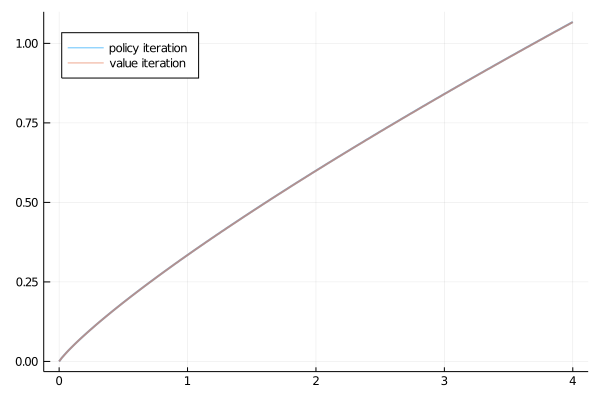

In [17]:
exercise2(m_ex, shocks, m.grid, m.u.(m.grid), sim_length=20)

The policies are indeed close.

### Solution to Exercise 4

Here’s the code.

It assumes that you’ve just run the code from the previous exercise

In [18]:
function bellman(m, shocks)
    @unpack grid, β, u, ∂u∂c, f, f′ = m
    bellman_single_arg(w) = T(w, grid, β, u, f, shocks)
    iterate_updating(bellman_single_arg, u.(grid), sim_length = 20)
end
function coleman(m, shocks)
    @unpack grid, β, ∂u∂c, f, f′ = m
    coleman_single_arg(g) = K(g, grid, β, ∂u∂c, f, f′, shocks)
    iterate_updating(coleman_single_arg, grid, sim_length = 20)
end

coleman (generic function with 1 method)

In [19]:
@benchmark bellman(m_ex, shocks)

BenchmarkTools.Trial: 
  memory estimate:  155.10 MiB
  allocs estimate:  90337
  --------------
  minimum time:     276.866 ms (10.21% GC)
  median time:      296.821 ms (10.98% GC)
  mean time:        295.370 ms (11.65% GC)
  maximum time:     315.779 ms (16.24% GC)
  --------------
  samples:          17
  evals/sample:     1

In [20]:
@benchmark bellman(m_ex, shocks)

BenchmarkTools.Trial: 
  memory estimate:  155.10 MiB
  allocs estimate:  90337
  --------------
  minimum time:     267.939 ms (13.36% GC)
  median time:      289.847 ms (12.41% GC)
  mean time:        290.370 ms (13.41% GC)
  maximum time:     330.942 ms (19.39% GC)
  --------------
  samples:          18
  evals/sample:     1